# 02 · Preprocessing — Augmentation, Normalization, and Train/Validation Split (PyTorch)

This notebook builds robust preprocessing for the traffic sign dataset:
- Image preprocessing experiments (resize/crop)
- Data augmentation testing (light/medium/strong)
- Normalization strategies (dataset, ImageNet, per-image)
- Stratified train/validation split and DataLoaders

In [1]:
# Section 1: Setup and Imports
import os
import json
import math
import random
from pathlib import Path

import numpy as np
import torch
from torch.utils.data import Subset, DataLoader
import torchvision
from torchvision import transforms
from torchvision.datasets import ImageFolder
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedShuffleSplit

print('Torch', torch.__version__, '| TorchVision', torchvision.__version__)

Torch 2.8.0+cpu | TorchVision 0.23.0+cpu


In [2]:
# Section 2: Configure Paths and Reproducibility
PROJECT_ROOT = Path.cwd().parents[0]
DATA_RAW = PROJECT_ROOT / 'data' / 'raw'
DATA_DIR = DATA_RAW / 'Train'  # directory-of-class-subfolders
OUTPUT_DIR = PROJECT_ROOT / 'data' / 'processed'
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

print('DATA_DIR:', DATA_DIR)
print('OUTPUT_DIR:', OUTPUT_DIR)

DATA_DIR: f:\VsCodeFolders\Work_Elevvo\Task_5\data\raw\Train
OUTPUT_DIR: f:\VsCodeFolders\Work_Elevvo\Task_5\data\processed


In [3]:
# Section 3: Load Image Dataset from Directory
# Assumes structure: data/raw/Train/<classId>/<image.png>
base_transform = transforms.Compose([
    transforms.ToTensor(),
])

dataset = ImageFolder(root=str(DATA_DIR), transform=base_transform)
class_to_idx = dataset.class_to_idx
idx_to_class = {v: k for k, v in class_to_idx.items()}

# Count images per class
counts = {}
for _, label in dataset.samples:
    counts[label] = counts.get(label, 0) + 1

print('Classes:', len(class_to_idx))
print('Sample image path example:', dataset.samples[0][0] if len(dataset.samples) else 'N/A')
print('Class mapping (first 10):', dict(list(class_to_idx.items())[:10]))
print('Counts (first 10):', dict(list(counts.items())[:10]))

Classes: 43
Sample image path example: f:\VsCodeFolders\Work_Elevvo\Task_5\data\raw\Train\0\00000_00000_00000.png
Class mapping (first 10): {'0': 0, '1': 1, '10': 2, '11': 3, '12': 4, '13': 5, '14': 6, '15': 7, '16': 8, '17': 9}
Counts (first 10): {0: 210, 1: 2220, 2: 2010, 3: 1320, 4: 2100, 5: 2160, 6: 780, 7: 630, 8: 420, 9: 1110}


In [4]:
# Section 4: Train/Validation Split (Stratified)
labels = [lbl for _, lbl in dataset.samples]
labels = np.array(labels)

splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=SEED)
train_idx, val_idx = next(splitter.split(np.zeros(len(labels)), labels))

train_subset = Subset(dataset, train_idx)
val_subset = Subset(dataset, val_idx)

split_path = OUTPUT_DIR / 'split_indices.json'
with open(split_path, 'w') as f:
    json.dump({'train_idx': train_idx.tolist(), 'val_idx': val_idx.tolist()}, f)

print('Train size:', len(train_subset), 'Val size:', len(val_subset))
print('Saved split to', split_path)

Train size: 31367 Val size: 7842
Saved split to f:\VsCodeFolders\Work_Elevvo\Task_5\data\processed\split_indices.json


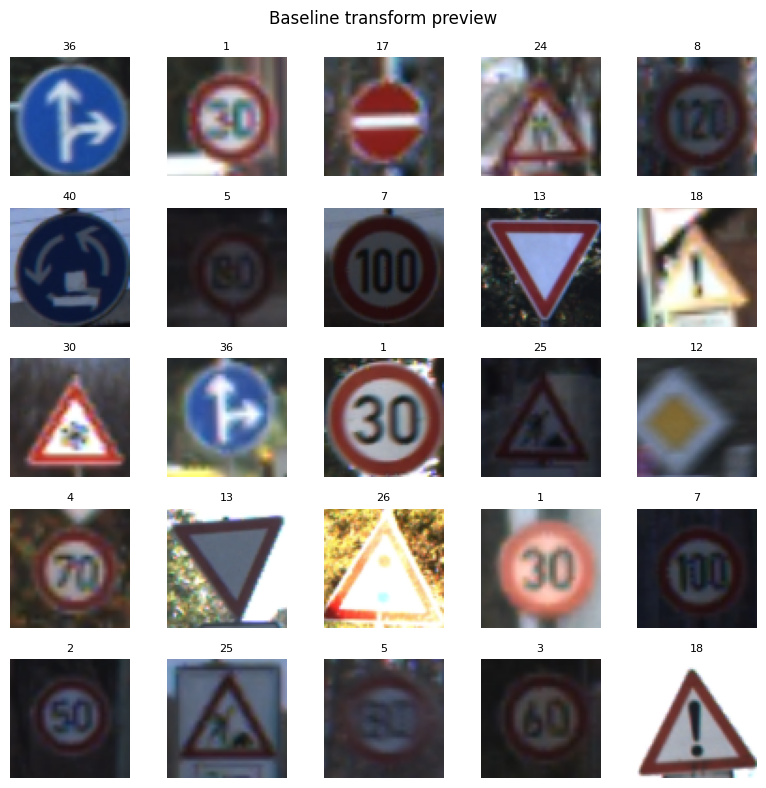

In [5]:
# Section 5: Baseline Resize/Center-Crop Pipeline
IMG_SIZE = 64

def baseline_transform(img_size=IMG_SIZE):
    return transforms.Compose([
        transforms.Resize(int(img_size * 1.15)),
        transforms.CenterCrop(img_size),
        transforms.ToTensor(),
    ])

# Preview a small grid from training subset
preview_ds = ImageFolder(root=str(DATA_DIR), transform=baseline_transform(IMG_SIZE))
preview_subset = Subset(preview_ds, train_idx[:25])

fig, axes = plt.subplots(5, 5, figsize=(8, 8))
axes = axes.flatten()
for i in range(len(preview_subset)):
    img, lbl = preview_subset[i]
    axes[i].imshow(np.transpose(img.numpy(), (1, 2, 0)))
    axes[i].set_title(dataset.classes[lbl], fontsize=8)
    axes[i].axis('off')
for j in range(i+1, len(axes)):
    axes[j].axis('off')
plt.suptitle('Baseline transform preview')
plt.tight_layout()
plt.show()

In [6]:
# Section 6: Data Augmentation Pipeline Variants

def aug_light(img_size=IMG_SIZE):
    return transforms.Compose([
        transforms.RandomResizedCrop(img_size, scale=(0.9, 1.0), ratio=(0.9, 1.1)),
        transforms.RandomHorizontalFlip(p=0.2),
        transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.05, hue=0.02),
        transforms.ToTensor(),
    ])

def aug_medium(img_size=IMG_SIZE):
    return transforms.Compose([
        transforms.RandomResizedCrop(img_size, scale=(0.75, 1.0), ratio=(0.9, 1.1)),
        transforms.RandomHorizontalFlip(p=0.3),
        transforms.RandomRotation(degrees=10),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.1, hue=0.03),
        transforms.RandomGrayscale(p=0.05),
        transforms.ToTensor(),
    ])

def aug_strong(img_size=IMG_SIZE):
    return transforms.Compose([
        transforms.RandomResizedCrop(img_size, scale=(0.6, 1.0), ratio=(0.85, 1.15)),
        transforms.RandomHorizontalFlip(p=0.4),
        transforms.RandomRotation(degrees=15),
        transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.15, hue=0.05),
        transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 1.0)),
        transforms.RandomGrayscale(p=0.1),
        transforms.ToTensor(),
    ])

print('Augmentations ready')

Augmentations ready


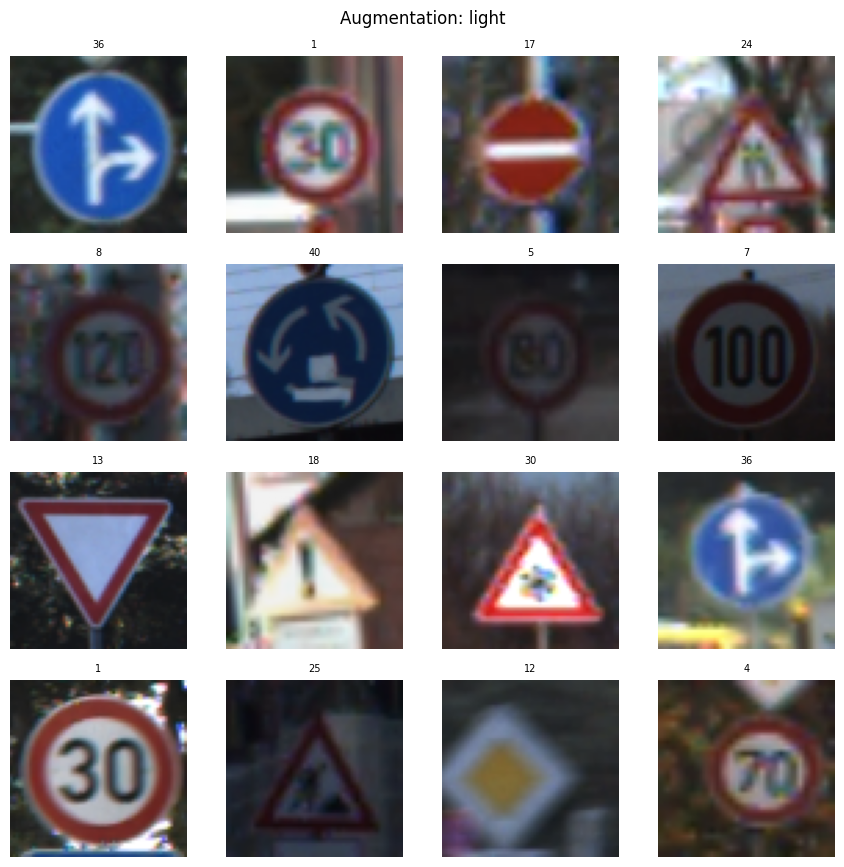

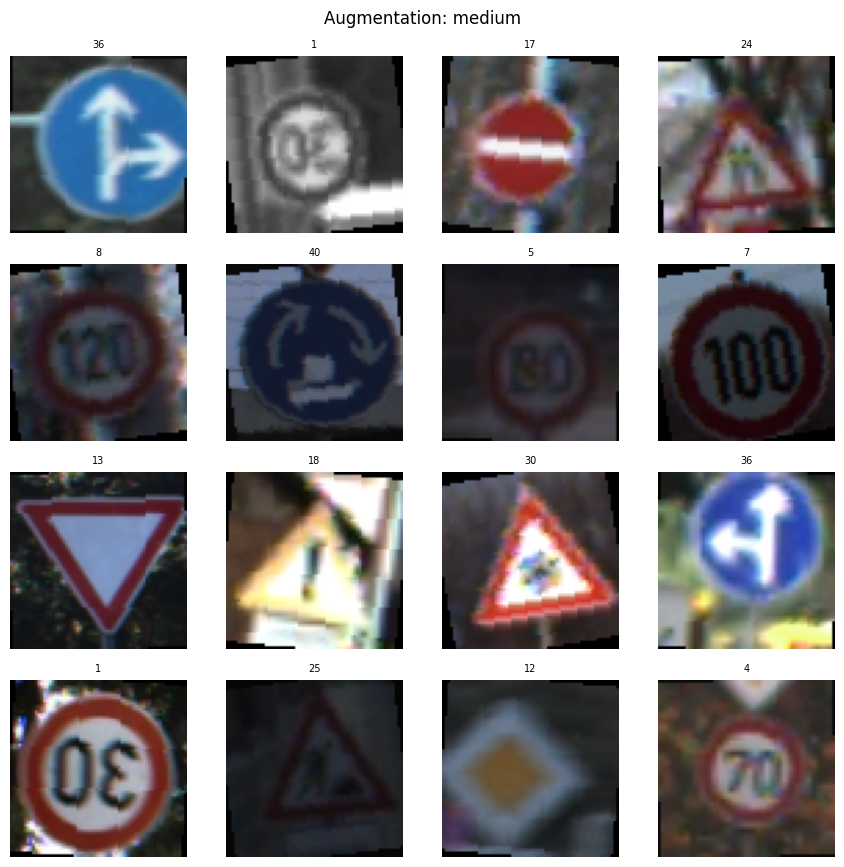

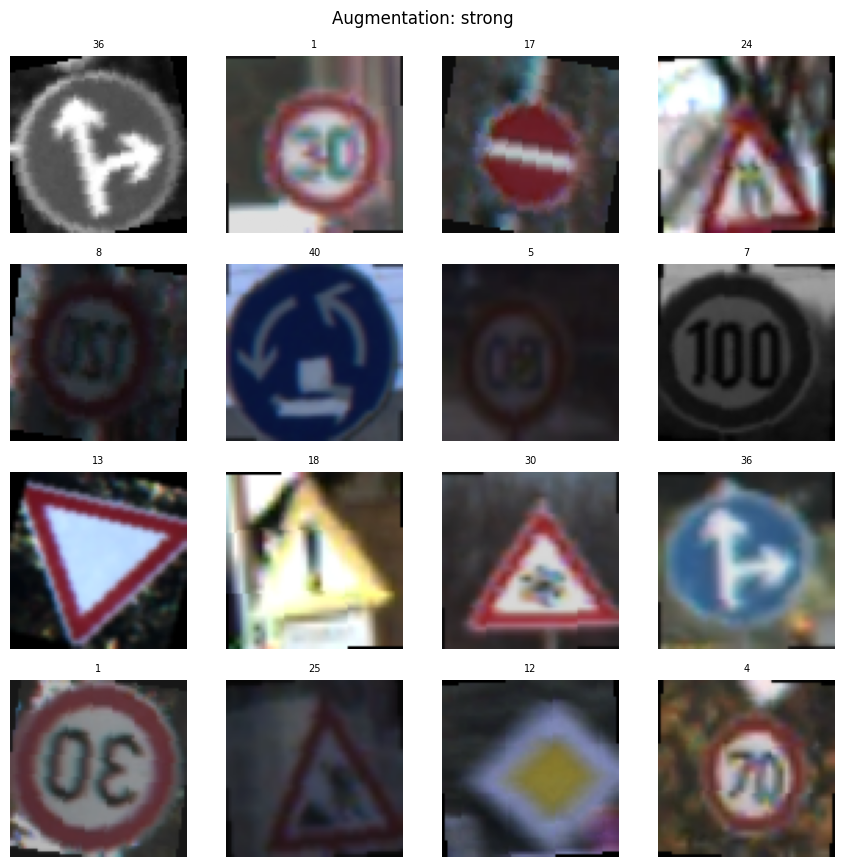

In [7]:
# Section 7: Augmentation Sanity Checks (Grid Preview)

def preview_aug(ds, idxs, title, n=16):
    subset = Subset(ds, idxs[:n])
    cols = int(math.sqrt(n))
    rows = math.ceil(n / cols)
    fig, axes = plt.subplots(rows, cols, figsize=(cols*2.2, rows*2.2))
    axes = np.array(axes).reshape(-1)
    for i in range(n):
        img, lbl = subset[i]
        axes[i].imshow(np.transpose(img.numpy(), (1, 2, 0)))
        axes[i].set_title(dataset.classes[lbl], fontsize=7)
        axes[i].axis('off')
    for j in range(i+1, len(axes)):
        axes[j].axis('off')
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

aug_datasets = {
    'light': ImageFolder(root=str(DATA_DIR), transform=aug_light(IMG_SIZE)),
    'medium': ImageFolder(root=str(DATA_DIR), transform=aug_medium(IMG_SIZE)),
    'strong': ImageFolder(root=str(DATA_DIR), transform=aug_strong(IMG_SIZE)),
}

for name, ds in aug_datasets.items():
    preview_aug(ds, train_idx, f'Augmentation: {name}', n=16)

In [8]:
# Section 8: Compute Dataset Statistics (Mean/Std Per Channel)
stat_ds = ImageFolder(root=str(DATA_DIR), transform=baseline_transform(IMG_SIZE))
stat_subset = Subset(stat_ds, train_idx)

loader = DataLoader(stat_subset, batch_size=128, num_workers=2, shuffle=False)

n_pixels = 0
sum_c = torch.zeros(3)
sum_sq_c = torch.zeros(3)
for x, _ in loader:
    # x: [B, C, H, W] in [0,1]
    b = x.size(0)
    n_pixels += b * x.size(2) * x.size(3)
    sum_c += x.sum(dim=[0, 2, 3])
    sum_sq_c += (x ** 2).sum(dim=[0, 2, 3])

mean = (sum_c / n_pixels).tolist()
std = (torch.sqrt(sum_sq_c / n_pixels - torch.tensor(mean) ** 2)).tolist()

stats_path = OUTPUT_DIR / 'dataset_stats.json'
with open(stats_path, 'w') as f:
    json.dump({'mean': mean, 'std': std, 'img_size': IMG_SIZE}, f, indent=2)

print('Computed mean/std:', {'mean': mean, 'std': std}, 'saved to', stats_path)

Computed mean/std: {'mean': [0.3496650755405426, 0.3148052394390106, 0.3279748558998108], 'std': [0.27440086007118225, 0.260507732629776, 0.26867857575416565]} saved to f:\VsCodeFolders\Work_Elevvo\Task_5\data\processed\dataset_stats.json


In [9]:
# Section 9: Normalization Strategies (Computed vs Predefined)
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD = [0.229, 0.224, 0.225]

with open(OUTPUT_DIR / 'dataset_stats.json') as f:
    ds_stats = json.load(f)
DS_MEAN = ds_stats['mean']
DS_STD = ds_stats['std']

class PerImageStandardize(torch.nn.Module):
    def forward(self, x):
        # x: [C,H,W]
        mean = x.mean(dim=[1,2], keepdim=True)
        std = x.std(dim=[1,2], keepdim=True) + 1e-6
        return (x - mean) / std

norm_options = {
    'none': transforms.Lambda(lambda x: x),
    'imagenet': transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD),
    'dataset': transforms.Normalize(mean=DS_MEAN, std=DS_STD),
    'per_image': PerImageStandardize(),
}
print('Normalization options:', list(norm_options.keys()))

Normalization options: ['none', 'imagenet', 'dataset', 'per_image']


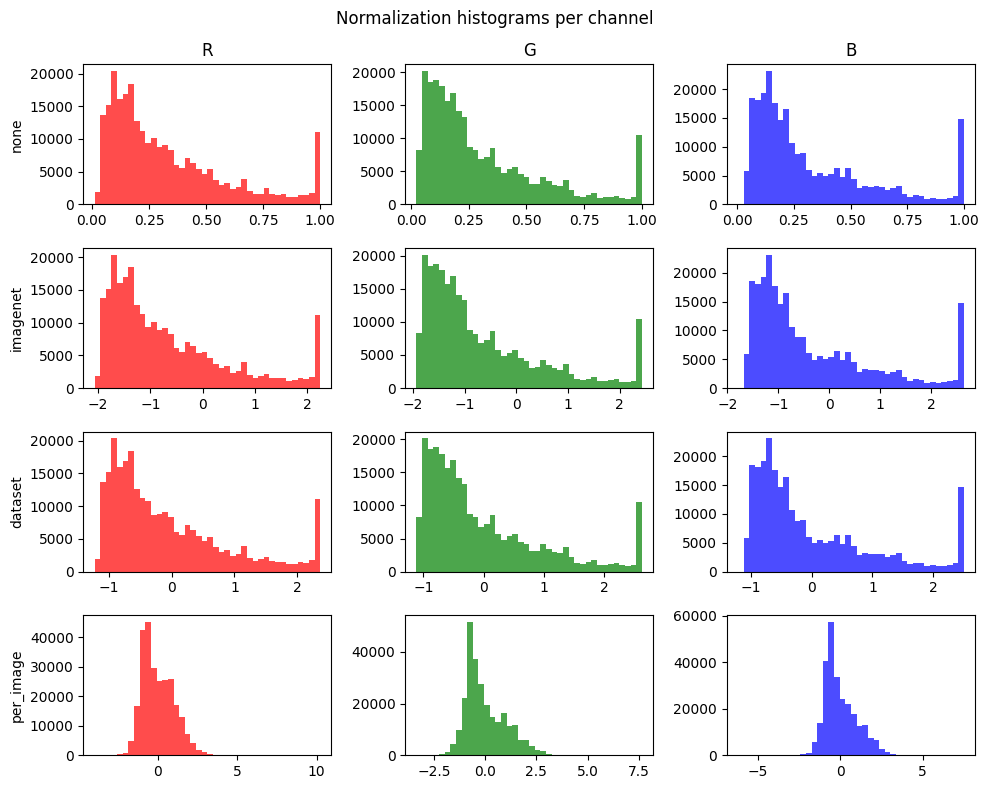

none -> mean: [0.328, 0.309, 0.328] std: [0.256, 0.251, 0.264]
imagenet -> mean: [-0.684, -0.658, -0.348] std: [1.12, 1.119, 1.174]
dataset -> mean: [-0.078, -0.024, -0.001] std: [0.934, 0.962, 0.983]
per_image -> mean: [-0.0, -0.0, -0.0] std: [1.0, 1.0, 1.0]


In [10]:
# Section 10: Apply and Compare Normalization (Histograms/Summaries)
compare_ds = ImageFolder(root=str(DATA_DIR), transform=baseline_transform(IMG_SIZE))
compare_subset = Subset(compare_ds, train_idx[:64])

# Build a small batch tensor [N,C,H,W]
imgs = []
for i in range(len(compare_subset)):
    x, _ = compare_subset[i]
    imgs.append(x)
stack = torch.stack(imgs, dim=0)

fig, axes = plt.subplots(4, 3, figsize=(10, 8))
for r, (name, norm) in enumerate(norm_options.items()):
    x = stack.clone()
    x = x.view(-1, x.size(2), x.size(3))  # not needed; keep per-image
    xn = torch.stack([norm(img) for img in stack], dim=0)
    # Per-channel histograms
    for c in range(3):
        ax = axes[r, c]
        vals = xn[:, c, :, :].flatten().numpy()
        ax.hist(vals, bins=40, color=['r','g','b'][c], alpha=0.7)
        if c == 0:
            ax.set_ylabel(name)
        if r == 0:
            ax.set_title(['R','G','B'][c])
plt.suptitle('Normalization histograms per channel')
plt.tight_layout()
plt.show()

# Simple summary stats
for name, norm in norm_options.items():
    xn = torch.stack([norm(img) for img in stack], dim=0)
    mu = xn.mean(dim=[0,2,3]).tolist()
    sd = xn.std(dim=[0,2,3]).tolist()
    print(name, '-> mean:', [round(v,3) for v in mu], 'std:', [round(v,3) for v in sd])

In [11]:
# Section 11: Build Torch DataLoaders
CHOSEN_AUG = 'medium'   # options: light|medium|strong
CHOSEN_NORM = 'dataset' # options: none|imagenet|dataset|per_image
BATCH_SIZE = 128
NUM_WORKERS = 2

aug_map = {
    'light': aug_light(IMG_SIZE),
    'medium': aug_medium(IMG_SIZE),
    'strong': aug_strong(IMG_SIZE),
}

train_tf = transforms.Compose([
    aug_map[CHOSEN_AUG],
    norm_options[CHOSEN_NORM],
])
val_tf = transforms.Compose([
    baseline_transform(IMG_SIZE),
    norm_options[CHOSEN_NORM],
])

train_full = ImageFolder(root=str(DATA_DIR), transform=train_tf)
val_full = ImageFolder(root=str(DATA_DIR), transform=val_tf)

train_ds = Subset(train_full, train_idx)
val_ds = Subset(val_full, val_idx)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)

xb, yb = next(iter(train_loader))
print('Train batch:', xb.shape, xb.dtype, '| labels:', yb.shape)
xbv, ybv = next(iter(val_loader))
print('Val batch:', xbv.shape, xbv.dtype, '| labels:', ybv.shape)

f:\VsCodeFolders\Work_Elevvo\Task_5\.venv\Lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Train batch: torch.Size([128, 3, 64, 64]) torch.float32 | labels: torch.Size([128])
Val batch: torch.Size([128, 3, 64, 64]) torch.float32 | labels: torch.Size([128])
Val batch: torch.Size([128, 3, 64, 64]) torch.float32 | labels: torch.Size([128])


In [12]:
# Section 12: Export Preprocessed Samples and Metadata
export_dir = OUTPUT_DIR / 'samples'
export_dir.mkdir(parents=True, exist_ok=True)

# Save a small batch of preprocessed training images for visual inspection
xb, yb = next(iter(train_loader))
for i in range(min(16, xb.size(0))):
    x = xb[i]
    # Unnormalize if using dataset or imagenet stats for saving as PNG
    if CHOSEN_NORM in ('dataset', 'imagenet'):
        mean = torch.tensor(DS_MEAN if CHOSEN_NORM=='dataset' else IMAGENET_MEAN).view(3,1,1)
        std = torch.tensor(DS_STD if CHOSEN_NORM=='dataset' else IMAGENET_STD).view(3,1,1)
        x = (x * std + mean).clamp(0, 1)
    img = (x.detach().cpu().numpy().transpose(1,2,0) * 255).astype(np.uint8)
    Image.fromarray(img).save(export_dir / f'train_sample_{i:02d}.png')

config = {
    'img_size': IMG_SIZE,
    'augmentation': CHOSEN_AUG,
    'normalization': CHOSEN_NORM,
    'dataset_mean_std': {'mean': DS_MEAN, 'std': DS_STD},
    'batch_size': BATCH_SIZE,
    'num_workers': NUM_WORKERS,
    'classes': dataset.classes,
    'split_indices': {'train': len(train_idx), 'val': len(val_idx)},
}
with open(OUTPUT_DIR / 'preprocessing_config.json', 'w') as f:
    json.dump(config, f, indent=2)

print('Exported samples to', export_dir)
print('Saved config to', OUTPUT_DIR / 'preprocessing_config.json')

Exported samples to f:\VsCodeFolders\Work_Elevvo\Task_5\data\processed\samples
Saved config to f:\VsCodeFolders\Work_Elevvo\Task_5\data\processed\preprocessing_config.json
